# Grupo 1 - Smog predicition

Inicialmente se va a analizar el dataset proporcionado, buscando que variables pueden ser útiles para realizar el reto.

In [217]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

df = pd.read_csv('data/train.csv')
df.head()

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog
0,ab44e9bec15,2022,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,32,202,2
1,45926762371,2022,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,37,181,4
2,e9be56e153f,2022,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,24,274,2
3,077092760df,2022,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,35,189,1
4,c1c2579b795,2022,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,20,324,1


De un primer vistazo, algunos datos que pueden ser de utilidad para realizar la predicción podrían ser "Engine Size (L)", "Cylinders", "Transmission", "Fuel Type", "Comb (L/100 km)" y "CO2 Emissions (g/km)". 

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                586 non-null    object 
 1   Model Year                        586 non-null    int64  
 2   Make                              586 non-null    object 
 3   Model                             586 non-null    object 
 4   Vehicle Class                     586 non-null    object 
 5   Engine Size (L)                   586 non-null    float64
 6   Cylinders                         586 non-null    int64  
 7   Transmission                      586 non-null    object 
 8   Fuel Type                         586 non-null    object 
 9   Fuel Consumption City (L/100 km)  586 non-null    float64
 10  Hwy (L/100 km)                    586 non-null    float64
 11  Comb (L/100 km)                   586 non-null    float64
 12  Comb (mp

Hemos decidido dividir la columna "Transmission" para poder obtener el número de marchas ("Gears") y el tipo de transmisión ("Transmission") de cada coche.

In [219]:
df['Gears'] = df['Transmission'].str.extract('(\d+)')
df['Gears'] = pd.to_numeric(df['Gears'], errors='coerce')
df['Transmission'] = df['Transmission'].str.extract('(\D+)')
df

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog,Gears
0,ab44e9bec15,2022,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM,Z,10.0,7.0,8.7,32,202,2,7.0
1,45926762371,2022,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS,X,8.6,6.7,7.7,37,181,4,6.0
2,e9be56e153f,2022,Porsche,Panamera 4 ST,Full-size,2.9,6,AM,Z,12.8,10.2,11.7,24,274,2,8.0
3,077092760df,2022,Mazda,CX-3 4WD,Compact,2.0,4,AS,X,8.6,7.4,8.1,35,189,1,6.0
4,c1c2579b795,2022,Aston Martin,DBS V12,Minicompact,5.2,12,A,Z,16.4,10.7,13.8,20,324,1,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,4a15a420076,2022,BMW,M8 Gran Coupe Competition,Mid-size,4.4,8,AS,Z,16.1,11.0,13.8,20,322,1,8.0
582,1ff291b6f89,2022,Dodge,Charger (MDS),Full-size,5.7,8,A,X,14.7,9.4,12.3,23,289,1,8.0
583,ff3fb82f77b,2022,Ram,1500 4X4 EcoDiesel,Pickup truck: Standard,3.0,6,A,D,11.1,8.0,9.7,29,260,0,8.0
584,cf742d4b653,2022,Honda,Accord Sport/Touring,Full-size,2.0,4,AS,X,10.4,7.4,9.1,31,211,4,10.0


Es necesario pasar los valores categóricos a numéricos para poder visualizar los datos y entrenar el modelo correctamente.

In [220]:
#Fuel Type
df.loc[df["Fuel Type"] == "X", "Fuel Type"] = 0
df.loc[df["Fuel Type"] == "Z", "Fuel Type"] = 1
df.loc[df["Fuel Type"] == "D", "Fuel Type"] = 2
df.loc[df["Fuel Type"] == "E", "Fuel Type"] = 3
df.loc[df["Fuel Type"] == "N", "Fuel Type"] = 4

#Transmission
df.loc[df["Transmission"] == "A", "Transmission"] = 0
df.loc[df["Transmission"] == "AM", "Transmission"] = 1
df.loc[df["Transmission"] == "AS", "Transmission"] = 2
df.loc[df["Transmission"] == "AV", "Transmission"] = 3
df.loc[df["Transmission"] == "M", "Transmission"] = 4


#Vehicle Class
df.loc[df["Vehicle Class"] == "Compact", "Vehicle Class"] = 0
df.loc[df["Vehicle Class"] == "Full-size", "Vehicle Class"] = 1
df.loc[df["Vehicle Class"] == "Mid-size", "Vehicle Class"] = 2
df.loc[df["Vehicle Class"] == "Minicompact", "Vehicle Class"] = 3
df.loc[df["Vehicle Class"] == "Minivan", "Vehicle Class"] = 4
df.loc[df["Vehicle Class"] == "Minicompact", "Vehicle Class"] = 5
df.loc[df["Vehicle Class"] == "Pickup truck: Small", "Vehicle Class"] = 6
df.loc[df["Vehicle Class"] == "Pickup truck: Standard", "Vehicle Class"] = 7
df.loc[df["Vehicle Class"] == "SUV: Small", "Vehicle Class"] = 8
df.loc[df["Vehicle Class"] == "SUV: Standard", "Vehicle Class"] = 9
df.loc[df["Vehicle Class"] == "Special purpose vehicle", "Vehicle Class"] = 10
df.loc[df["Vehicle Class"] == "Station wagon: Mid-size", "Vehicle Class"] = 11
df.loc[df["Vehicle Class"] == "Station wagon: Small", "Vehicle Class"] = 12
df.loc[df["Vehicle Class"] == "Subcompact", "Vehicle Class"] = 13
df.loc[df["Vehicle Class"] == "Two-seater", "Vehicle Class"] = 14

Al analizar el dataset hemos detectado que la columna de "Model Year" es igual en todos los datos, por lo que hemos decidido suprimirla al no aportar gran información para realizar el modelo.

In [221]:
df.drop("Model Year", axis=1, inplace=True)
df.head()

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog,Gears
0,ab44e9bec15,Mercedes-Benz,A 250 4MATIC Hatch,12,2.0,4,1,1,10.0,7.0,8.7,32,202,2,7.0
1,45926762371,Mazda,Mazda3 5-Door,2,2.0,4,2,0,8.6,6.7,7.7,37,181,4,6.0
2,e9be56e153f,Porsche,Panamera 4 ST,1,2.9,6,1,1,12.8,10.2,11.7,24,274,2,8.0
3,077092760df,Mazda,CX-3 4WD,0,2.0,4,2,0,8.6,7.4,8.1,35,189,1,6.0
4,c1c2579b795,Aston Martin,DBS V12,3,5.2,12,0,1,16.4,10.7,13.8,20,324,1,8.0


También, hemos decidido eliminar las columnas de "Make" y "Model" porque no resultan útiles, al no aportar información relevante para calcular la clasificación de "Smog". Además, así podemos realizar un modelo menos complejo al tener menos características a ajustar.

In [222]:
df.drop("Make", axis=1, inplace=True)
df.drop("Model", axis=1, inplace=True)
df.head()

,id,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog,Gears
0,ab44e9bec15,12,2.0,4,1,1,10.0,7.0,8.7,32,202,2,7.0
1,45926762371,2,2.0,4,2,0,8.6,6.7,7.7,37,181,4,6.0
2,e9be56e153f,1,2.9,6,1,1,12.8,10.2,11.7,24,274,2,8.0
3,077092760df,0,2.0,4,2,0,8.6,7.4,8.1,35,189,1,6.0
4,c1c2579b795,3,5.2,12,0,1,16.4,10.7,13.8,20,324,1,8.0


In [223]:
df.drop("Comb (mpg)", axis=1, inplace=True)
df.head()

,id,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog,Gears
0,ab44e9bec15,12,2.0,4,1,1,10.0,7.0,8.7,202,2,7.0
1,45926762371,2,2.0,4,2,0,8.6,6.7,7.7,181,4,6.0
2,e9be56e153f,1,2.9,6,1,1,12.8,10.2,11.7,274,2,8.0
3,077092760df,0,2.0,4,2,0,8.6,7.4,8.1,189,1,6.0
4,c1c2579b795,3,5.2,12,0,1,16.4,10.7,13.8,324,1,8.0


Al igual, se eliminará la columna "Comb (mpg)" al ser una métrica equivalente a la anterior, pero en unidades del sistema anglosajón.

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

%matplotlib inline

In [225]:
#g = sns.PairGrid(df, hue="Smog")
#g.map_diag(plt.hist)
#g.map_offdiag(plt.scatter)
#g.add_legend()

Finalmente, eliminamos las columnas "Fuel Consumption City (L/100Km)" y "Hwy (L/100Km)" ya que estos datos se han combinado en la columna "Comb (L/100Km)", que será la que se usará como media del consumo de cada coche en ciudad y autopista en nuestro estudio. 

In [226]:
df.drop("Fuel Consumption City (L/100 km)", axis=1, inplace=True)
df.drop("Hwy (L/100 km)", axis=1, inplace=True)
df.head()

,id,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Comb (L/100 km),CO2 Emissions (g/km),Smog,Gears
0,ab44e9bec15,12,2.0,4,1,1,8.7,202,2,7.0
1,45926762371,2,2.0,4,2,0,7.7,181,4,6.0
2,e9be56e153f,1,2.9,6,1,1,11.7,274,2,8.0
3,077092760df,0,2.0,4,2,0,8.1,189,1,6.0
4,c1c2579b795,3,5.2,12,0,1,13.8,324,1,8.0


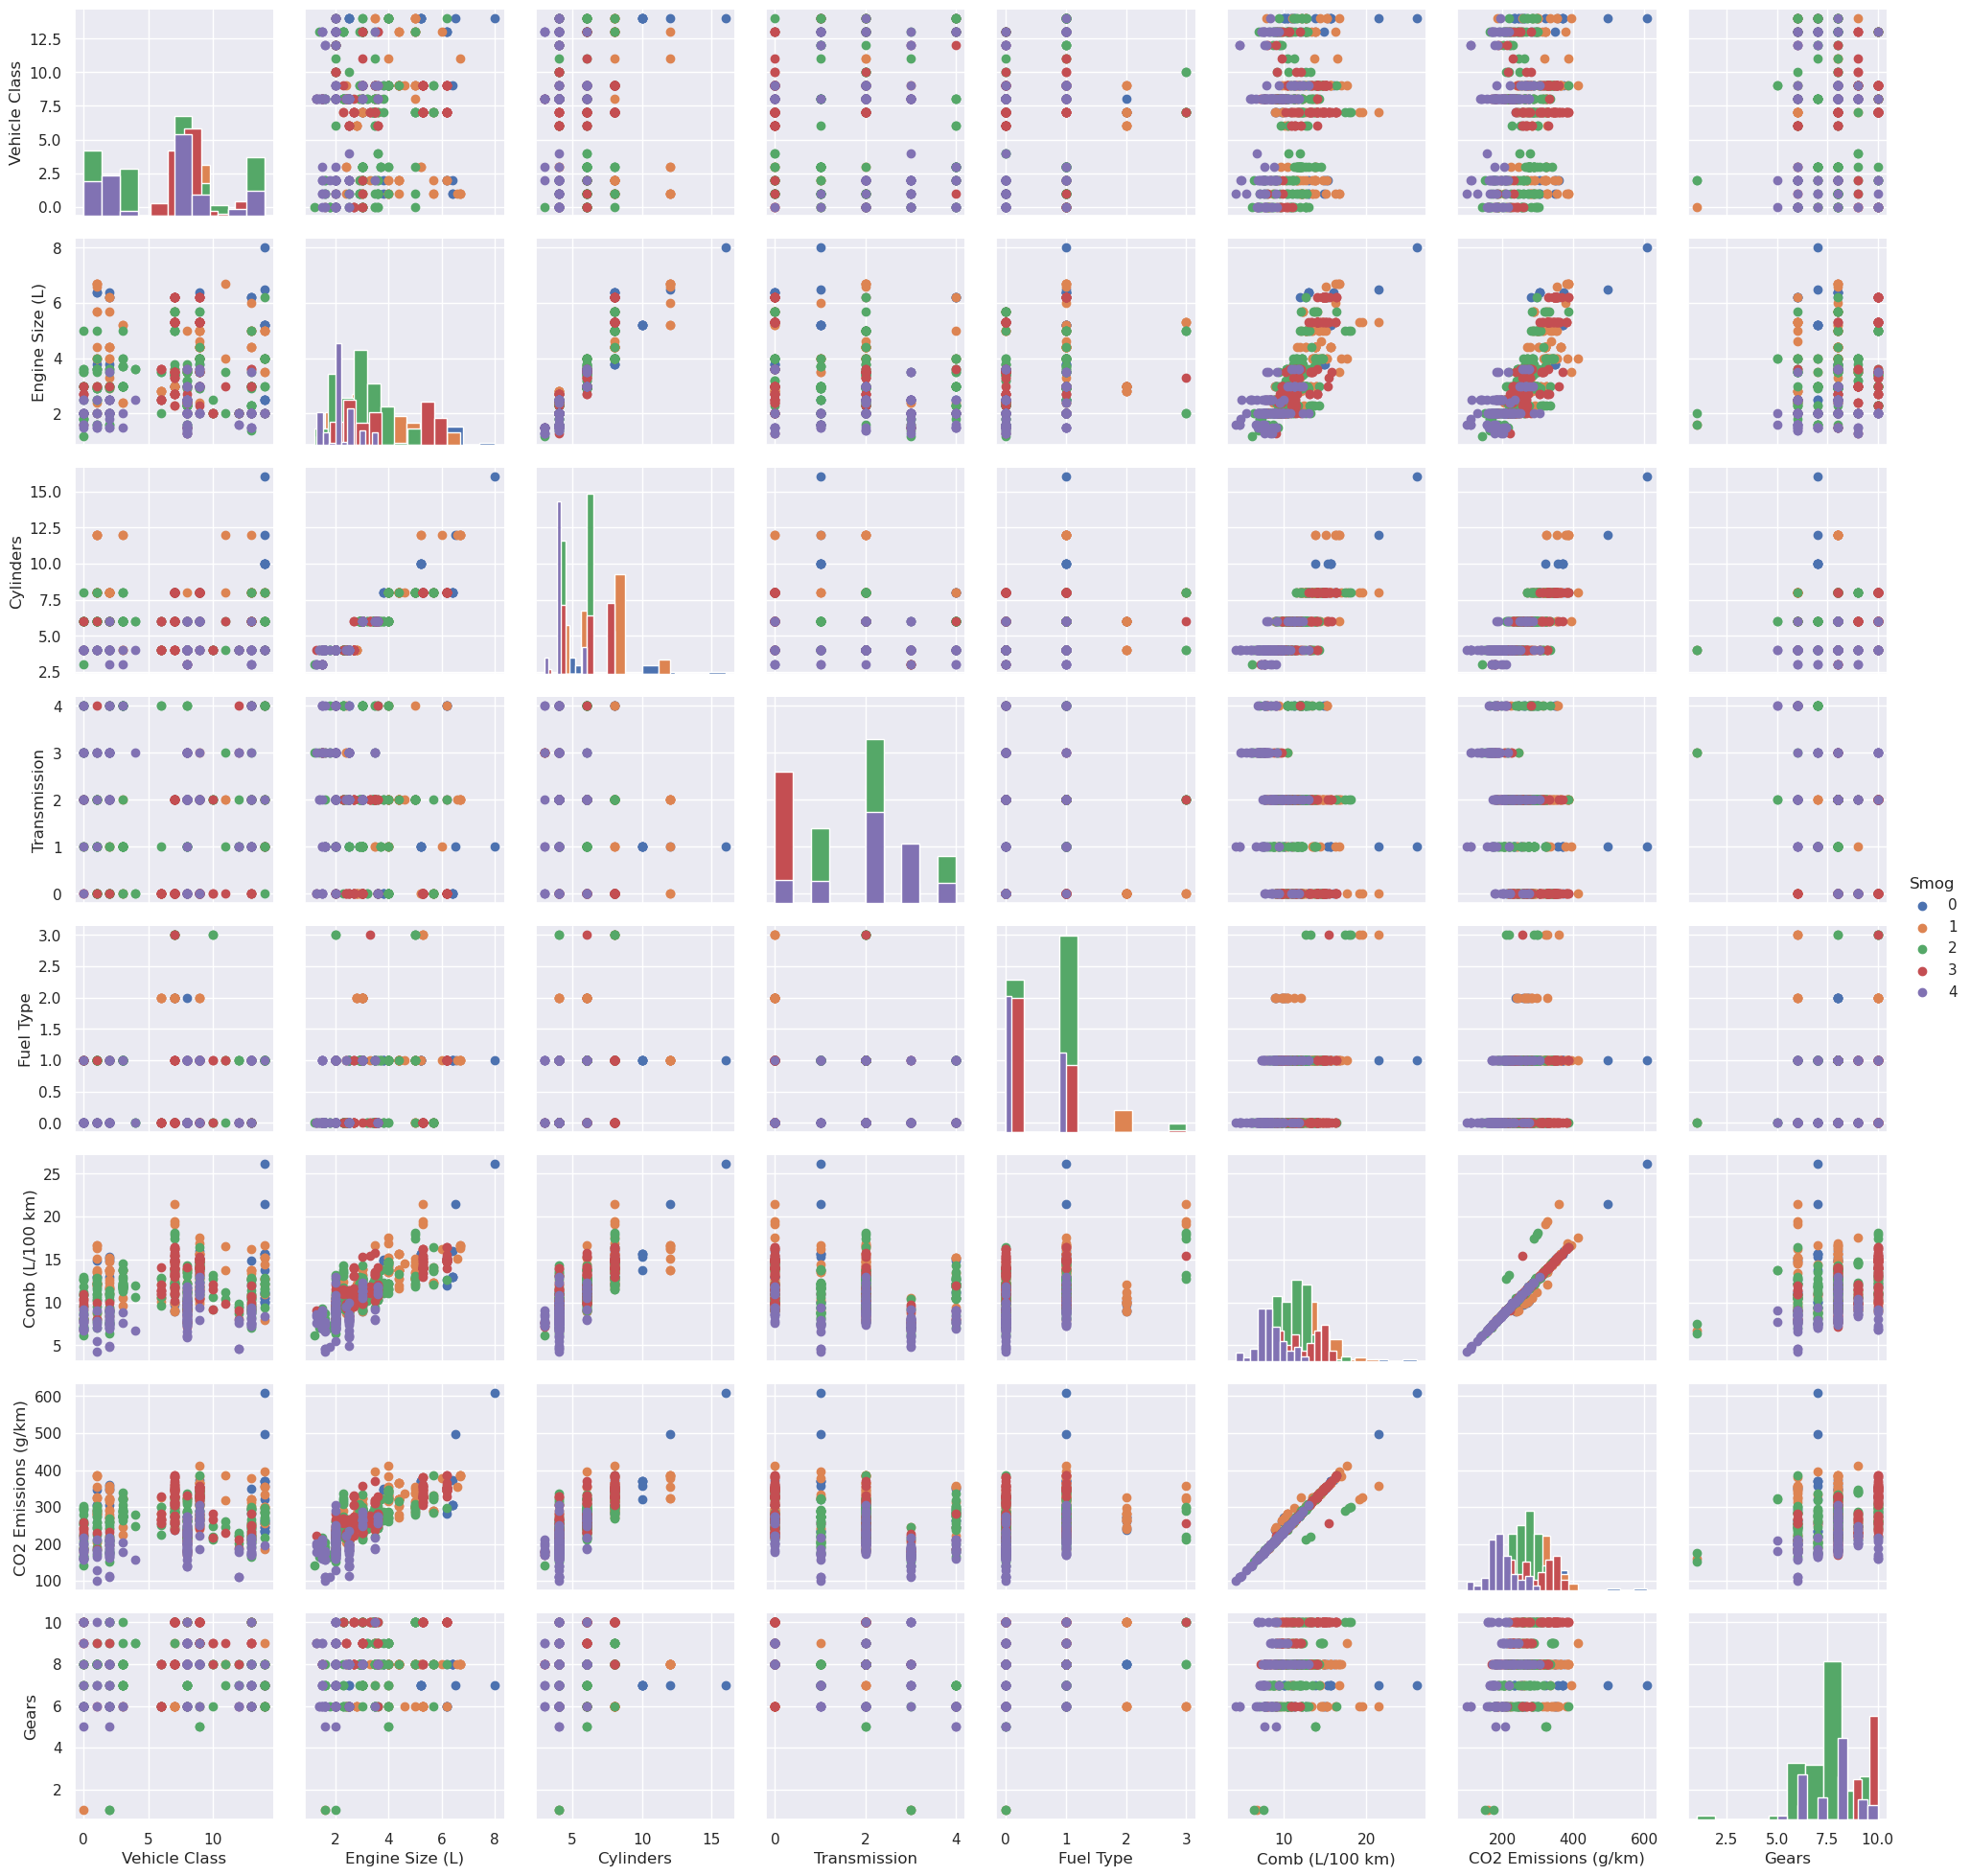

In [227]:
g = sns.PairGrid(df, hue="Smog")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

Tras observar los gráficos de las diferentes características correladas podemos deducir que las principales variables para la predicción son "Gears", "Fuel Type", "Cylinders" y "Transmission". En cambio, una de las variables que pensábamos que iban a ser de las más prometedoras era "Engine Size (L)", pero al final ha resultado ser de las menos correladas con el resto.